# Comparing the norm of various state vector variants

In [20]:
from os.path import join
from os import makedirs
import torch as pt
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "/home/andre/Development/naca0012_shock_buffet/run/oat15"
path = "./output/oat15_analysis/state_vector"

makedirs(path, exist_ok=True)

In [7]:
times = pt.load(join(data, "oat15_tandem_times.pt"))[::10]
vertices = pt.load(join(data, "vertices_and_masks.pt"))
area = vertices["area_small"]
del vertices
start_at, end_at = 101, 501 # encloses 2 cycles

In [3]:
norms = {}
weights = area.sqrt().unsqueeze(-1)
def add_norm_to_dict(dm, key):
    norms[key] = dm.norm(dim=0) / dm.mean(dim=1).norm()

# density
dm = pt.load(join(data, "rho_small_every10.pt"))[:, start_at:end_at:2]
add_norm_to_dict(dm, "rho")
add_norm_to_dict(dm*weights, "rho_w")
# velocity in x and z
vel_x = pt.load(join(data, "vel_x_small_every10.pt"))[:, start_at:end_at:2]
vel_z = pt.load(join(data, "vel_z_small_every10.pt"))[:, start_at:end_at:2]
dm = pt.cat((vel_x, vel_z), dim=0)
add_norm_to_dict(dm, "vel_xz")
add_norm_to_dict(dm*weights.repeat((2, 1)), "vel_xz_w")
# velocity in x, y, z
vel_y = pt.load(join(data, "vel_y_small_every10.pt"))[:, start_at:end_at:2]
dm = pt.cat((vel_x, vel_y, vel_z), dim=0)
add_norm_to_dict(dm, "vel_xyz")
add_norm_to_dict(dm*weights.repeat((3, 1)), "vel_xyz_w")
# velocity in x, z and local speed of sound
ma = pt.load(join(data, "ma_small_every10.pt"))[:, start_at:end_at:2]
speed = (vel_x**2 + vel_y**2 + vel_z**2).sqrt()
a_loc = speed / ma
kappa = pt.tensor(1.4)
scale = pt.sqrt(2.0 / (kappa * (kappa - 1.0)))
dm = pt.cat((vel_x, vel_z, a_loc*scale), dim=0)
add_norm_to_dict(dm, "vel_axz")
add_norm_to_dict(dm*weights.repeat((3, 1)), "vel_axz_w")
del dm, vel_x, vel_y, vel_z, ma, a_loc

In [31]:
for key, item in norms.items():
    print(key, (item.min().item()-1.0)*100, (item.max().item()-1.0)*100)

rho -0.9163022041320801 0.6185531616210938
rho_w -0.4259943962097168 0.25496482849121094
vel_xz -1.2295544147491455 2.273082733154297
vel_xz_w -0.6369113922119141 1.0447978973388672
vel_xyz -1.215118169784546 2.2730588912963867
vel_xyz_w -0.6216287612915039 1.044905185699463
vel_axz -0.05078315734863281 0.16745328903198242
vel_axz_w -0.011330842971801758 0.0734567642211914


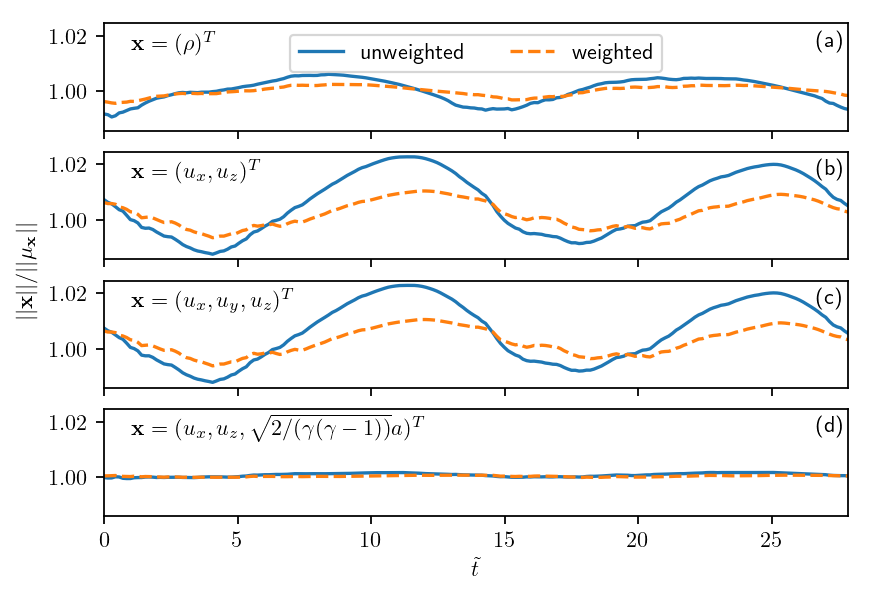

In [28]:
fig, axarr = plt.subplots(4, 1, figsize=(6, 4), sharex=True, sharey=True)
state_keys = ("rho", "vel_xz", "vel_xyz", "vel_axz")
state_labels = (r"$\mathbf{x}=(\rho)^T$", r"$\mathbf{x}=(u_x, u_z)^T$", r"$\mathbf{x}=(u_x, u_y, u_z)^T$", r"$\mathbf{x}=(u_x, u_z, \sqrt{2/(\gamma (\gamma -1))} a)^T$")
plot_labels = [f"({i})" for i in ("a", "b", "c", "d")]
CHORD = 0.15
U_INF = 238.59
times_norm = (times[start_at:end_at:2] - times[start_at]) * U_INF / CHORD
for i, state in enumerate(state_keys):
    axarr[i].plot(times_norm, norms[state], ls="-", c="C0", label="unweighted")
    axarr[i].plot(times_norm, norms[f"{state}_w"], ls="--", c="C1", label="weighted")
    axarr[i].text(1, 1.015, state_labels[i])
    axarr[i].text(26.65, 1.016, plot_labels[i])
axarr[0].legend(ncol=2, loc="upper center")
axarr[0].set_xlim(times_norm[0], times_norm[-1])
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel(r"$||\mathbf{x}|| / || \mu_\mathbf{x}||$", labelpad=10)
axarr[-1].set_xlabel(r"$\tilde{t}$")
plt.savefig(join(path, "state_norm.pdf"), bbox_inches="tight")
plt.savefig(join(path, "state_norm.svg"), bbox_inches="tight")
plt.savefig(join(path, "state_norm.png"), bbox_inches="tight")
plt.show()